In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling
from modAL.multilabel import SVM_binary_minimum
from modAL.expected_error import expected_error_reduction

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

In [2]:
# Loading data sets
full_data_BatchA = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/data/full_data_BatchA.csv')
y = full_data_BatchA['Label'].to_numpy()
X_morgan = full_data_BatchA.drop(['Label'], axis = 1).to_numpy()

In [3]:
# Only default values exept random state for replications
# NOTE: SVM can be use only if the model is a SVM classifier
svm_clf1 = SVC(random_state = 0, probability=True)
knn_clf1 = KNeighborsClassifier(n_jobs=-1)
rf_clf1 = RandomForestClassifier(max_depth=10, random_state=0, n_jobs = -1)
ada_clf1 = AdaBoostClassifier(n_estimators=10, random_state=0)

In [8]:
# Parameters for ML model
train_size = 0.3
test_size = 0.4

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_morgan, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [9]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 930
The inicial pool set has size 2172
The inicial test set has size 2069


In [10]:
# Parameters for AL
N_QUERIES = 1#int(2*len(x_pool)/3)

#Timer
tic=timeit.default_timer()

cf_mat_x_clssifr = []
prfmc_x_classifr = []
Classifiers = [svm_clf1,knn_clf1, rf_clf1, ada_clf1]
save = True
for classifier in Classifiers:
    
    print(f'********** Training with {str(classifier)}')
    
    prfmc_his, cf_mat_his, learner= fun.active_learnig_train(n_queries = N_QUERIES, x_train = x_train, y_train = y_train, 
                                               x_test = x_test, y_test = y_test, x_pool = x_pool, 
                                               y_pool = y_pool, Classifier = classifier, query_str = expected_error_reduction)
    prfmc_x_classifr.append(prfmc_his)
    cf_mat_x_clssifr.append(cf_mat_his)
    
    #Saving model
    if save:
        filename = "".join(["/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/density_experiments/dens_euclidean_default_models", str(classifier),'.sav'])
        pickle.dump(learner, open(filename, 'wb'))
    
toc=timeit.default_timer()
print(f'\n\nElapsed time: {toc-tic} seconds')

********** Training with SVC(probability=True, random_state=0)
Accuracy after query 1: 0.9894
********** Training with KNeighborsClassifier(n_jobs=-1)
Accuracy after query 1: 0.9894
********** Training with RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=0)
Accuracy after query 1: 0.9894
********** Training with AdaBoostClassifier(n_estimators=10, random_state=0)
Accuracy after query 1: 0.9894


Elapsed time: 16654.393123414367 seconds


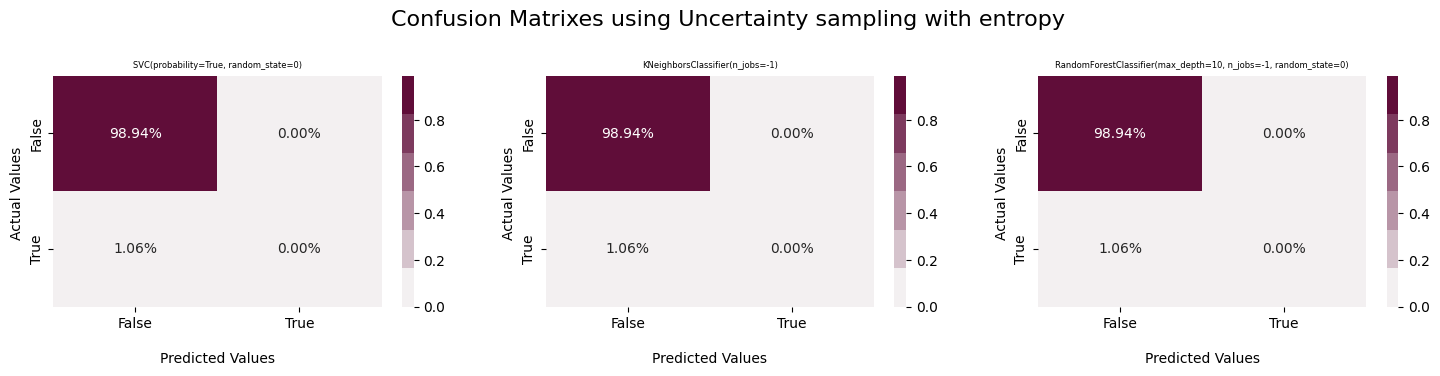

In [11]:
#Plot
fig, axes = plt.subplots(1, 3, figsize=(18,3))
i = 0
for row in axes:
    fun.plot_cf_mat(matrix = cf_mat_x_clssifr[i][-1], sub_title = str(Classifiers[i]) ,save = False, figure_name = None, ax=row)
    i+=1
fig.suptitle('Confusion Matrixes using Uncertainty sampling with entropy\n', fontsize=16, y =1.1)
plt.show()